# UFC Outcome XGBoost Baseline
This notebook builds a simple gradient-boosted tree baseline (XGBoost) to predict fight outcomes — red win, blue win, or draw/no contest — using the scraped UFC fight statistics.


## Prerequisites
Install dependencies in your active environment if they are not already available:
```bash
pip install xgboost scikit-learn pandas matplotlib seaborn requests beautifulsoup4 python-dateutil
```


In [61]:

import numpy as np
import pandas as pd
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

from xgboost import XGBClassifier

import requests
from bs4 import BeautifulSoup
from dateutil import parser as dateparser
from pandas.api.types import is_numeric_dtype

pd.options.display.max_columns = 120


In [62]:

fights = pd.read_csv(DATA_DIR / "fights.csv")
totals_overall = pd.read_csv(DATA_DIR / "fight_totals_overall.csv")
sig_overall = pd.read_csv(DATA_DIR / "fight_sig_overall.csv")

fights.head()


,fight_id,fight_url,event_id,event_date,red_id,red_name,red_result,blue_id,blue_name,blue_result,method,referee,end_round,end_time
0,1a191251620a84ca,http://ufcstats.com/fight-details/1a191251620a...,00a905a4a4a2b071,2022-09-03,77d7295d1b22c694,Alessio Di Chirico,L,9d83f6da776ff7d6,Roman Kopylov,W,KO/TKO,Rich Mitchell,3,1:09
1,20f316f96c9e4458,http://ufcstats.com/fight-details/20f316f96c9e...,00a905a4a4a2b071,2022-09-03,881bf86d4cba8578,Nassourdine Imavov,W,b9437600497350f3,Joaquin Buckley,L,Decision - Unanimous,Marc Goddard,3,5:00
2,398db40015b3c81c,http://ufcstats.com/fight-details/398db40015b3...,00a905a4a4a2b071,2022-09-03,e1d40e8782d80bc2,William Gomis,W,082eba4cd80f736f,Jarno Errens,L,Decision - Majority,Jason Herzog,3,5:00
3,3e2f00991f511607,http://ufcstats.com/fight-details/3e2f00991f51...,00a905a4a4a2b071,2022-09-03,c2299ec916bc7c56,Benoit Saint Denis,W,b909a9a9688b5284,Gabriel Miranda,L,KO/TKO,Jason Herzog,2,0:16
4,7bced112f3229b1b,http://ufcstats.com/fight-details/7bced112f322...,00a905a4a4a2b071,2022-09-03,c21a036b4e012f1c,John Makdessi,L,b7b84ccd221be298,Nasrat Haqparast,W,Decision - Unanimous,Marc Goddard,3,5:00


## Feature Engineering
Each totals/sig table contains one row per fighter per fight. We reshape them so that features for the red and blue corners sit on the same row, and then add difference features (red minus blue).

In [63]:

fights_df = fights.copy()
fights_df['fight_id'] = fights_df['fight_id'].astype(str)
fights_df['red_id'] = fights_df['red_id'].astype(str)
fights_df['blue_id'] = fights_df['blue_id'].astype(str)
fights_df['event_date'] = pd.to_datetime(fights_df['event_date'])

fighters_info = pd.read_csv(DATA_DIR / "fighters.csv")
fighters_info['fighter_id'] = fighters_info['fighter_id'].astype(str)
fighters_info['dob'] = pd.to_datetime(fighters_info['dob'], errors='coerce')

def prepare_stat_table(df: pd.DataFrame, prefix: str) -> pd.DataFrame:
    df = df[df["level"] == "overall"].copy()
    if df.empty:
        return pd.DataFrame(columns=["fight_id", "fighter_id", "event_date"])
    df['fight_id'] = df['fight_id'].astype(str)
    df['fighter_id'] = df['fighter_id'].astype(str)

    df = df.merge(fights_df[['fight_id', 'event_date']], on='fight_id', how='left')
    if 'event_date_x' in df.columns:
        df['event_date'] = df['event_date_x']
    if 'event_date_y' in df.columns and df['event_date'].isna().any():
        df['event_date'] = df['event_date'].fillna(df['event_date_y'])
    if 'event_date' not in df.columns:
        df['event_date'] = pd.NaT
    df['event_date'] = pd.to_datetime(df['event_date'])

    drop_cols = {
        'fight_id', 'fighter_id', 'event_id', 'event_date', 'event_date_x', 'event_date_y',
        'level', 'round', 'table'
    }
    stat_cols = [c for c in df.columns if c not in drop_cols]

    renamed = df[['fight_id', 'fighter_id', 'event_date'] + stat_cols].rename(
        columns={c: f"{prefix}_{c}" for c in stat_cols}
    )
    return renamed

tot_stats = prepare_stat_table(totals_overall, 'tot')
sig_stats = prepare_stat_table(sig_overall, 'sig')

fighter_stats = tot_stats.merge(sig_stats, on=['fight_id', 'fighter_id', 'event_date'], how='left')
fighter_stats = fighter_stats.sort_values(['fighter_id', 'event_date']).reset_index(drop=True)

stat_cols = [c for c in fighter_stats.columns if c not in ['fight_id', 'fighter_id', 'event_date']]

def compute_history(group: pd.DataFrame) -> pd.DataFrame:
    group = group.sort_values('event_date').copy()
    stats = group[stat_cols].fillna(0)
    cumsum = stats.cumsum()
    prior_sum = cumsum.shift(1)
    counts = pd.Series(range(len(group)), index=group.index)
    prior_mean = prior_sum.divide(counts.replace(0, np.nan), axis=0)
    out = pd.DataFrame({
        'fight_id': group['fight_id'],
        'fighter_id': group['fighter_id'],
        'event_date': group['event_date'],
        'prior_fights': counts
    }, index=group.index)
    out = pd.concat([out, prior_mean.add_prefix('mean_')], axis=1)
    return out

history = fighter_stats.groupby('fighter_id', group_keys=False).apply(compute_history).reset_index(drop=True)

history_lookup = {
    fid: grp.sort_values('event_date').reset_index(drop=True)
    for fid, grp in history.groupby('fighter_id')
}
fighters_lookup = fighters_info.set_index('fighter_id').to_dict('index')

len(history), len(history_lookup)


/var/folders/f_/bwshrttd7xd3kfqpgh3nwz040000gn/T/ipykernel_18643/1927192764.py:62: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  history = fighter_stats.groupby('fighter_id', group_keys=False).apply(compute_history).reset_index(drop=True)


(16684, 2603)

In [64]:

def get_latest_history(fighter_id: str, event_date: pd.Timestamp):
    fighter_id = str(fighter_id)
    hist = history_lookup.get(fighter_id)
    if hist is None:
        return None
    prior = hist[hist['event_date'] < event_date]
    if prior.empty:
        return None
    return prior.iloc[-1]

def build_matchup_features(matchups: pd.DataFrame,
                           require_history: bool = True) -> pd.DataFrame:
    records = []
    for row in matchups.itertuples(index=False):
        event_date = pd.to_datetime(getattr(row, 'event_date'))
        red_hist = get_latest_history(getattr(row, 'red_id'), event_date)
        blue_hist = get_latest_history(getattr(row, 'blue_id'), event_date)

        if red_hist is None or blue_hist is None:
            if require_history:
                continue
            history_available = False
        else:
            history_available = True

        base = row._asdict()
        base['event_date'] = event_date
        base['history_available'] = history_available

        if history_available:
            base['red_prior_fights'] = red_hist['prior_fights']
            base['blue_prior_fights'] = blue_hist['prior_fights']
            for col, val in red_hist.items():
                if col in {'fight_id', 'fighter_id', 'event_date', 'prior_fights'}:
                    continue
                base[f'red_{col}'] = val
            for col, val in blue_hist.items():
                if col in {'fight_id', 'fighter_id', 'event_date', 'prior_fights'}:
                    continue
                base[f'blue_{col}'] = val

        for corner in ['red', 'blue']:
            fid = str(base.get(f'{corner}_id'))
            info = fighters_lookup.get(fid, {})
            base.setdefault('history_available', history_available)
            base[f'{corner}_height_in'] = info.get('height_in') if info else None
            base[f'{corner}_reach_in'] = info.get('reach_in') if info else None
            base[f'{corner}_stance'] = info.get('stance') if info else None
            dob = info.get('dob') if info else None
            if pd.notna(dob):
                base[f'{corner}_age'] = (event_date - dob).days / 365.25
            else:
                base[f'{corner}_age'] = None

        records.append(base)

    result = pd.DataFrame(records)
    if require_history and not result.empty:
        result = result[result['history_available']].copy()
    return result

def prepare_feature_matrix(df: pd.DataFrame, feature_columns=None):
    data = df.copy()

    for col in list(data.columns):
        if col.startswith('red_') and is_numeric_dtype(data[col]):
            base = col[4:]
            blue_col = f'blue_{base}'
            if blue_col in data.columns and is_numeric_dtype(data[blue_col]):
                diff_name = f'diff_{base}'
                if diff_name not in data:
                    data[diff_name] = data[col] - data[blue_col]

    for col in ['red_stance', 'blue_stance']:
        if col in data.columns:
            data[col] = data[col].fillna('Unknown')
    stance_cols = [c for c in ['red_stance', 'blue_stance'] if c in data.columns]
    if stance_cols:
        stance_dummies = pd.get_dummies(data[stance_cols], columns=stance_cols)
        data = pd.concat([data, stance_dummies], axis=1)

    drop_cols = [
        'history_available',
        'fight_id',
        'event_id',
        'event_date',
        'red_id',
        'blue_id',
        'red_name',
        'blue_name',
        'red_stance',
        'blue_stance'
    ]
    drop_cols = [c for c in drop_cols if c in data.columns]
    data = data.drop(columns=drop_cols, errors='ignore')

    numeric_data = data.select_dtypes(include=[np.number])
    if feature_columns is None:
        feature_columns = numeric_data.columns.tolist()
        return numeric_data, feature_columns
    numeric_data = numeric_data.reindex(columns=feature_columns, fill_value=0)
    return numeric_data, feature_columns


In [65]:

matchups_all = fights_df[['fight_id', 'event_id', 'event_date', 'red_id', 'blue_id', 'red_name', 'blue_name']].copy()
training_features = build_matchup_features(matchups_all, require_history=True)

outcome_cols = fights[['fight_id', 'red_result', 'blue_result']]
train_df = training_features.merge(outcome_cols, on='fight_id', how='left')

def map_outcome(row: pd.Series) -> int | None:
    red = (row.get('red_result') or '').strip().upper()
    blue = (row.get('blue_result') or '').strip().upper()
    if red.startswith('W'):
        return 0  # red win
    if blue.startswith('W'):
        return 1  # blue win
    if red.startswith('D') or blue.startswith('D'):
        return 2
    if 'NC' in red or 'NC' in blue:
        return 2
    return None

train_df['target'] = train_df.apply(map_outcome, axis=1)
train_df = train_df.dropna(subset=['target']).reset_index(drop=True)
train_df[['fight_id', 'red_name', 'blue_name', 'red_prior_fights', 'blue_prior_fights', 'target']].head()


,fight_id,red_name,blue_name,red_prior_fights,blue_prior_fights,target
0,1a191251620a84ca,Alessio Di Chirico,Roman Kopylov,9,1,1
1,20f316f96c9e4458,Nassourdine Imavov,Joaquin Buckley,3,6,0
2,7bced112f3229b1b,John Makdessi,Nasrat Haqparast,17,8,1
3,810c9da07970c4a6,Ciryl Gane,Tai Tuivasa,7,10,0
4,acc9a109b00a99e1,Charles Jourdain,Nathaniel Wood,8,6,1


In [66]:

USE_TIME_SPLIT = True  # Set False to use random stratified split

feature_base = train_df.drop(columns=['target', 'red_result', 'blue_result'])
X_all, FEATURE_COLUMNS = prepare_feature_matrix(feature_base)
y = train_df['target'].astype(int)

if USE_TIME_SPLIT:
    ordered = train_df[['fight_id', 'event_date']].sort_values('event_date').reset_index(drop=True)
    unique_fights = ordered['fight_id'].tolist()
    cutoff = int(len(unique_fights) * 0.8)
    train_ids = set(unique_fights[:cutoff])
    test_ids = set(unique_fights[cutoff:])

    train_mask = train_df['fight_id'].isin(train_ids)
    test_mask = train_df['fight_id'].isin(test_ids)

    X_train = X_all[train_mask]
    y_train = y[train_mask]
    X_test = X_all[test_mask]
    y_test = y[test_mask]
else:
    X_train, X_test, y_train, y_test = train_test_split(
        X_all, y, test_size=0.2, random_state=42, stratify=y
    )

X_train.shape, X_test.shape


((4971, 93), (1243, 93))

In [67]:
X_train.head()

,red_prior_fights,blue_prior_fights,red_mean_tot_kd,red_mean_tot_sig_str_landed,red_mean_tot_sig_str_attempted,red_mean_tot_sig_str_pct,red_mean_tot_total_str_landed,red_mean_tot_total_str_attempted,red_mean_tot_td_landed,red_mean_tot_td_attempted,red_mean_tot_td_pct,red_mean_tot_sub_att,red_mean_tot_rev,red_mean_tot_ctrl_seconds,red_mean_sig_sig_str_landed,red_mean_sig_sig_str_attempted,red_mean_sig_sig_str_pct,red_mean_sig_head_landed,red_mean_sig_head_attempted,red_mean_sig_body_landed,red_mean_sig_body_attempted,red_mean_sig_leg_landed,red_mean_sig_leg_attempted,red_mean_sig_distance_landed,red_mean_sig_distance_attempted,red_mean_sig_clinch_landed,red_mean_sig_clinch_attempted,red_mean_sig_ground_landed,red_mean_sig_ground_attempted,blue_mean_tot_kd,blue_mean_tot_sig_str_landed,blue_mean_tot_sig_str_attempted,blue_mean_tot_sig_str_pct,blue_mean_tot_total_str_landed,blue_mean_tot_total_str_attempted,blue_mean_tot_td_landed,blue_mean_tot_td_attempted,blue_mean_tot_td_pct,blue_mean_tot_sub_att,blue_mean_tot_rev,blue_mean_tot_ctrl_seconds,blue_mean_sig_sig_str_landed,blue_mean_sig_sig_str_attempted,blue_mean_sig_sig_str_pct,blue_mean_sig_head_landed,blue_mean_sig_head_attempted,blue_mean_sig_body_landed,blue_mean_sig_body_attempted,blue_mean_sig_leg_landed,blue_mean_sig_leg_attempted,blue_mean_sig_distance_landed,blue_mean_sig_distance_attempted,blue_mean_sig_clinch_landed,blue_mean_sig_clinch_attempted,blue_mean_sig_ground_landed,blue_mean_sig_ground_attempted,red_height_in,red_reach_in,red_age,blue_height_in,blue_reach_in,blue_age,diff_prior_fights,diff_mean_tot_kd,diff_mean_tot_sig_str_landed,diff_mean_tot_sig_str_attempted,diff_mean_tot_sig_str_pct,diff_mean_tot_total_str_landed,diff_mean_tot_total_str_attempted,diff_mean_tot_td_landed,diff_mean_tot_td_attempted,diff_mean_tot_td_pct,diff_mean_tot_sub_att,diff_mean_tot_rev,diff_mean_tot_ctrl_seconds,diff_mean_sig_sig_str_landed,diff_mean_sig_sig_str_attempted,diff_mean_sig_sig_str_pct,diff_mean_sig_head_landed,diff_mean_sig_head_attempted,diff_mean_sig_body_landed,diff_mean_sig_body_attempted,diff_mean_sig_leg_landed,diff_mean_sig_leg_attempted,diff_mean_sig_distance_landed,diff_mean_sig_distance_attempted,diff_mean_sig_clinch_landed,diff_mean_sig_clinch_attempted,diff_mean_sig_ground_landed,diff_mean_sig_ground_attempted,diff_height_in,diff_reach_in,diff_age
0,9,1,0.333333,37.222222,90.666667,41.333333,46.444444,101.222222,1.222222,2.666667,35.000000,0.000000,0.0,71.666667,37.222222,90.666667,41.333333,25.000000,72.888889,6.666667,11.111111,5.555556,6.666667,30.555556,79.666667,4.888889,7.555556,1.777778,3.444444,0.000000,37.000000,95.000000,38.000000,38.000,96.000000,0.000000,1.000000,0.000000,0.000000,0.000000,2.000000,37.000000,95.000000,38.000000,19.00,72.000000,15.000000,20.000000,3.000000,3.000000,37.000000,95.000000,0.000000,0.000000,0.000,0.000000,72.0,74.0,32.725530,72.0,75.0,31.334702,8,0.333333,0.222222,-4.333333,3.333333,8.444444,5.222222,1.222222,1.666667,35.000000,0.000000,0.000000,69.666667,0.222222,-4.333333,3.333333,6.000000,0.888889,-8.333333,-8.888889,2.555556,3.666667,-6.444444,-15.333333,4.888889,7.555556,1.777778,3.444444,0.0,-1.0,1.390828
1,3,6,0.000000,54.666667,99.666667,54.000000,71.333333,117.666667,0.666667,3.000000,37.333333,1.333333,0.0,123.000000,54.666667,99.666667,54.000000,40.333333,81.000000,11.333333,15.000000,3.000000,3.666667,35.333333,72.333333,15.000000,16.333333,4.333333,11.000000,0.666667,34.500000,95.166667,33.666667,39.000,100.000000,1.166667,3.333333,21.333333,0.000000,0.000000,64.666667,34.500000,95.166667,33.666667,17.00,67.833333,13.166667,22.333333,4.333333,5.000000,28.833333,87.666667,3.166667,4.333333,2.500,3.166667,75.0,75.0,26.507871,70.0,76.0,28.353183,-3,-0.666667,20.166667,4.500000,20.333333,32.333333,17.666667,-0.500000,-0.333333,16.000000,1.333333,0.000000,58.333333,20.166667,4.500000,20.333333,23.333333,13.166667,-1.833333,-7.333333,-1.333333,-1.333333,6.500000,-15.333333,11.833333,12.000000,1.833333,7.833333,5.0,

In [68]:

model = XGBClassifier(
    n_estimators=500,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.9,
    objective="multi:softprob",
    eval_metric="mlogloss",
    num_class=3,
    tree_method="hist",
    random_state=42,
)

model.fit(X_train, y_train)


,objective,'multi:softprob'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.9
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'mlogloss'


              precision    recall  f1-score   support

     Red win       0.62      0.76      0.68       685
    Blue win       0.56      0.42      0.48       534
     Draw/NC       0.00      0.00      0.00        24

    accuracy                           0.60      1243
   macro avg       0.39      0.39      0.39      1243
weighted avg       0.58      0.60      0.58      1243



/Users/acheung/Documents/GitHub/UFCPredictor/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/acheung/Documents/GitHub/UFCPredictor/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/acheung/Documents/GitHub/UFCPredictor/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this beha

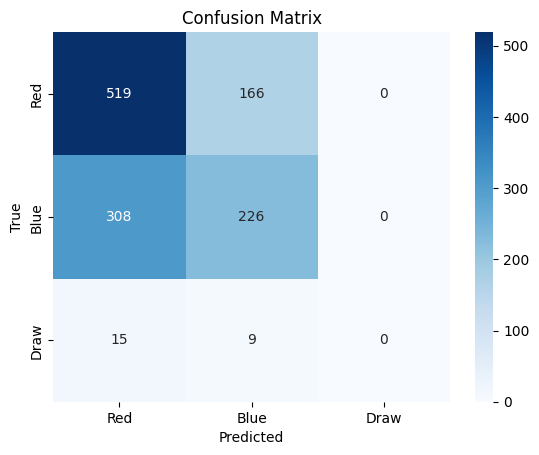

In [69]:

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=["Red win", "Blue win", "Draw/NC"]))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Red", "Blue", "Draw"],
            yticklabels=["Red", "Blue", "Draw"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


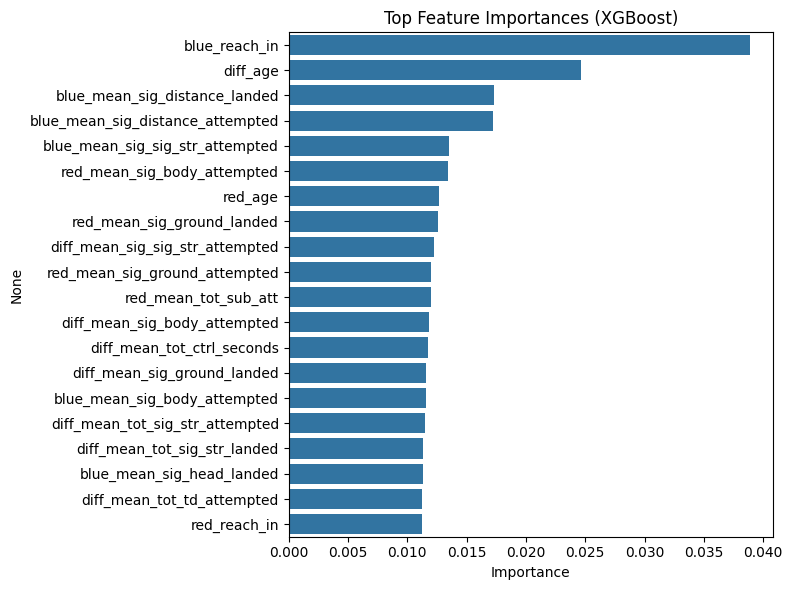

In [70]:

importance = pd.Series(model.feature_importances_, index=X_train.columns)
top_features = importance.sort_values(ascending=False).head(20)

plt.figure(figsize=(8, 6))
sns.barplot(x=top_features.values, y=top_features.index)
plt.title("Top Feature Importances (XGBoost)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()


## Next Steps
* Incorporate fighter history (recent fight averages, win streaks).
* Include event metadata (weight class, main event).
* Hyperparameter tuning (e.g., with Optuna or cross-validation).
* Address class imbalance (draws/NC are rare) via class weights or focal objectives.

In [41]:

BASE_URL = "http://ufcstats.com"
HEADERS = {
    "User-Agent": "UFC predictor (mailto:you@example.com)",
    "Accept-Language": "en-US,en;q=0.9",
}

def normalize_url(url: str) -> str:
    if not url:
        return url
    url = url.strip()
    return url

def clean(text: str) -> str:
    return ' '.join((text or '').split())

def soup(url: str) -> BeautifulSoup:
    response = requests.get(normalize_url(url), headers=HEADERS, timeout=30)
    response.raise_for_status()
    return BeautifulSoup(response.text, 'html.parser')

def parse_fight_participants(fight_url: str) -> dict:
    page = soup(fight_url)
    persons = page.select('div.b-fight-details__person')
    if len(persons) < 2:
        raise ValueError('Could not locate fighter blocks')

    def side(div):
        link = div.select_one('a.b-link.b-fight-details__person-link')
        name = clean(link.get_text()) if link else ''
        href = normalize_url(link['href']) if link else None
        fid = href.rsplit('/', 1)[-1] if href else None
        return name, fid

    red_name, red_id = side(persons[0])
    blue_name, blue_id = side(persons[1])
    fight_id = fight_url.rstrip('/').rsplit('/', 1)[-1]
    return {
        'fight_id': fight_id,
        'fight_url': fight_url,
        'red_id': red_id,
        'red_name': red_name,
        'blue_id': blue_id,
        'blue_name': blue_name,
    }

def fetch_event_matchups(event_url: str) -> pd.DataFrame:
    page = soup(event_url)
    info_items = [clean(li.get_text()) for li in page.select('li.b-list__box-list-item')]
    date_txt = next((item.split(':', 1)[1].strip() for item in info_items if item.lower().startswith('date:')), None)
    event_date = pd.Timestamp(dateparser.parse(date_txt).date()) if date_txt else pd.Timestamp.today()
    event_id = normalize_url(event_url).rstrip('/').rsplit('/', 1)[-1]

    fight_links = set()
    for a in page.select('a[href*="/fight-details/"]'):
        href = a.get('href')
        if href:
            fight_links.add(normalize_url(href))
    for tr in page.select('tr[data-link*="/fight-details/"]'):
        data_link = tr.get('data-link') or tr.get('data-link-url') or tr.get('data-href')
        if data_link:
            fight_links.add(normalize_url(data_link))

    bouts = []
    for link in sorted(fight_links):
        try:
            bout = parse_fight_participants(link)
            bout['event_id'] = event_id
            bout['event_date'] = event_date
            bouts.append(bout)
        except Exception:
            continue
    matchups = pd.DataFrame(bouts)
    if not matchups.empty:
        matchups['red_id'] = matchups['red_id'].astype(str)
        matchups['blue_id'] = matchups['blue_id'].astype(str)
    return matchups

def predict_event(event_url: str, model=model, feature_columns=None) -> pd.DataFrame:
    feature_columns = feature_columns or FEATURE_COLUMNS
    matchups = fetch_event_matchups(event_url)
    if matchups.empty:
        raise ValueError('No fights found at the provided event URL.')

    features_df = build_matchup_features(matchups, require_history=False)
    if features_df.empty:
        raise ValueError('Unable to construct features for any fights (missing history).')

    available = features_df[features_df['history_available']].copy()
    missing = features_df[~features_df['history_available']]
    if available.empty:
        raise ValueError('No fights have sufficient history for prediction.')

    X_pred, _ = prepare_feature_matrix(available, feature_columns=feature_columns)
    probabilities = model.predict_proba(X_pred)

    predictions = available[['fight_id', 'event_date', 'red_name', 'blue_name', 'red_prior_fights', 'blue_prior_fights']].copy()
    predictions[['prob_red_win', 'prob_blue_win', 'prob_draw']] = probabilities
    predictions['prediction'] = predictions[['prob_red_win', 'prob_blue_win', 'prob_draw']].idxmax(axis=1)

    if not missing.empty:
        print('Fights skipped due to insufficient history:', missing[['fight_id', 'red_name', 'blue_name']].to_dict('records'))

    return predictions.sort_values('prob_red_win', ascending=False).reset_index(drop=True)


In [42]:

# Example usage (uncomment and run to generate predictions for an event)
event_url = "http://ufcstats.com/event-details/8944a0f9b2f0ce6d"
predict_event(event_url)


Fights skipped due to insufficient history: [{'fight_id': 'b09ecdc8ef0f0d20', 'red_name': 'Patchy Mix', 'blue_name': 'Jakub Wiklacz'}]


,fight_id,event_date,red_name,blue_name,red_prior_fights,blue_prior_fights,prob_red_win,prob_blue_win,prob_draw,prediction
0,a8511df8285f5c91,2025-10-04,Merab Dvalishvili,Cory Sandhagen,14.0,14.0,0.872867,0.124918,0.002215,prob_red_win
1,2560ea97b2cce4ef,2025-10-04,Jiri Prochazka,Khalil Rountree Jr.,6.0,16.0,0.802276,0.188488,0.009236,prob_red_win
2,98883348ddb3be33,2025-10-04,Veronica Hardy,Brogan Walker,8.0,1.0,0.794822,0.195411,0.009767,prob_red_win
3,1c7cc3a22ab7d907,2025-10-04,Edmen Shahbazyan,Andre Muniz,12.0,8.0,0.769260,0.220096,0.010643,prob_red_win
4,a951090fb402fd20,2025-10-04,Punahele Soriano,Nikolay Veretennikov,8.0,2.0,0.659578,0.333269,0.007153,prob_red_win
5,b98bc1ecb94ef4a5,2025-10-04,Ramiz Brahimaj,Austin Vanderford,6.0,0.0,0.572999,0.418396,0.008605,prob_red_win
6,8353b491afa7bc32,2025-10-04,Macy Chiasson,Yana Santos,11.0,10.0,0.566857,0.428063,0.005079,prob_red_win
7,0de1ef0b9f3a79c0,2025-10-04,Magomed Ankalaev,Alex Pereira,14.0,10.0,0.551145,0.446182,0.002674,prob_red_win
8,7b34aa1eb09b8301,2025-10-04,Daniel Santos,JooSang Yoo,3.0,0.0,0.536612,0.461502,0.001886,prob_red_win
9,e53fd165a3bc1f8e,2025-10-04,Chris Gutierrez,Farid Basharat,13.0,3.0,0.517568,0.470952,0.011481,prob_red_win
